In [5]:
import os
import io
import zipfile
import requests
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (7,4)


Train class counts: [3859  598]
Test class counts: [966 149]

--- Decision Stump Baseline ---
Train accuracy: 0.8918555081893651
Test accuracy : 0.8869955156950673
Confusion matrix (test):
[[961   5]
 [121  28]]

Iteration 1
Misclassified indices: [9, 15, 22, 31, 39, 49, 59, 66, 76, 88] ...
Misclassified weights: [0.001037, 0.001037, 0.001037, 0.001037, 0.001037, 0.001037, 0.001037, 0.001037, 0.001037, 0.001037] ...
Alpha: 1.0549179565189157

Iteration 2
Misclassified indices: [15, 31, 39, 49, 50, 59, 66, 76, 86, 88] ...
Misclassified weights: [0.001248, 0.001248, 0.001248, 0.001248, 0.000151, 0.001248, 0.001248, 0.001248, 0.000151, 0.001248] ...
Alpha: 0.17042295829756252

Iteration 3
Misclassified indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10] ...
Misclassified weights: [0.000127, 0.000127, 0.000127, 0.000127, 0.000127, 0.000127, 0.000127, 0.000127, 0.000127, 0.000127] ...
Alpha: 0.1539130349717022

Iteration 4
Misclassified indices: [9, 15, 22, 31, 39, 49, 50, 59, 62, 66] ...
Misclassifie

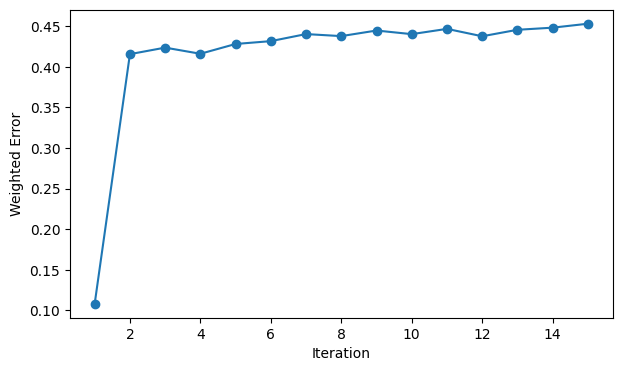

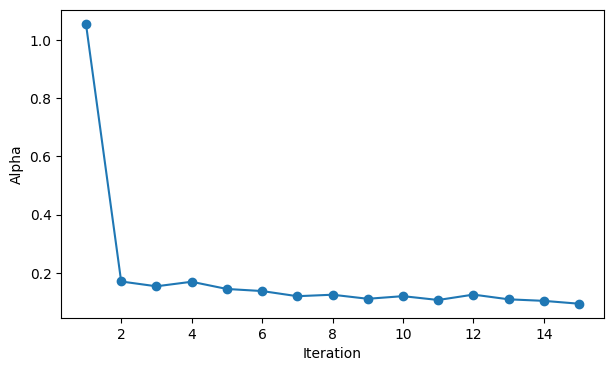


--- Manual AdaBoost Results ---
Train accuracy: 0.8925286066861118
Test accuracy : 0.8878923766816144
Confusion matrix (test):
[[961   5]
 [120  29]]

--- Sklearn AdaBoost ---
Train accuracy: 0.9046443796275522
Test accuracy : 0.905829596412556
Confusion matrix (test):
[[966   0]
 [105  44]]


In [10]:


df = pd.read_csv("spam.csv", encoding="latin-1")
df = df.iloc[:, :2]   # keep only first 2 columns
df.columns = ["label", "text"]

df["label_num"] = df["label"].map({"ham":0, "spam":1})
df["text_proc"] = (
    df["text"]
    .astype(str)
    .str.lower()
    .str.replace(r"[^\w\s]", " ", regex=True)
)

from sklearn.feature_extraction import _stop_words
stop = set(_stop_words.ENGLISH_STOP_WORDS)

df["text_proc"] = df["text_proc"].apply(
    lambda s: " ".join([w for w in s.split() if w not in stop])
)

vect = TfidfVectorizer()
X = vect.fit_transform(df["text_proc"])
y = df["label_num"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train class counts:", np.bincount(y_train))
print("Test class counts:", np.bincount(y_test))




stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)
ytr = stump.predict(X_train)
yte = stump.predict(X_test)

print("\n--- Decision Stump Baseline ---")
print("Train accuracy:", accuracy_score(y_train, ytr))
print("Test accuracy :", accuracy_score(y_test, yte))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, yte))



def manual_adaboost_text(X_train, y_train, X_test, y_test, T=15):
    n = X_train.shape[0]
    w = np.ones(n) / n
    y_signed = np.where(y_train == 1, 1, -1)

    models = []
    errors = []
    alphas = []

    for t in range(1, T + 1):
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X_train, y_train, sample_weight=w)

        pred = clf.predict(X_train)
        pred_signed = np.where(pred == 1, 1, -1)

        mis = (pred != y_train)
        err = np.sum(w[mis])
        err = max(min(err, 0.999999), 1e-12)

        alpha = 0.5 * np.log((1 - err) / err)

        w = w * np.exp(-alpha * y_signed * pred_signed)
        w = w / np.sum(w)

        mis_idx = np.where(mis)[0]

        print(f"\nIteration {t}")
        print("Misclassified indices:", mis_idx[:10].tolist(), "...")   # show first 10
        print("Misclassified weights:", w[mis_idx][:10].round(6).tolist(), "...")
        print("Alpha:", float(alpha))

        errors.append(err)
        alphas.append(alpha)
        models.append((clf, alpha))

    # plots
    plt.plot(range(1, T + 1), errors, marker="o")
    plt.xlabel("Iteration")
    plt.ylabel("Weighted Error")
    plt.show()

    plt.plot(range(1, T + 1), alphas, marker="o")
    plt.xlabel("Iteration")
    plt.ylabel("Alpha")
    plt.show()

    def predict_boosted(X):
        agg = np.zeros(X.shape[0])
        for m, a in models:
            pred = m.predict(X)
            pred_signed = np.where(pred == 1, 1, -1)
            agg += a * pred_signed
        return np.where(agg > 0, 1, 0)

    ytr_pred = predict_boosted(X_train)
    yte_pred = predict_boosted(X_test)

    print("\n--- Manual AdaBoost Results ---")
    print("Train accuracy:", accuracy_score(y_train, ytr_pred))
    print("Test accuracy :", accuracy_score(y_test, yte_pred))
    print("Confusion matrix (test):")
    print(confusion_matrix(y_test, yte_pred))

    return models, errors, alphas


models, errors, alphas = manual_adaboost_text(X_train, y_train, X_test, y_test, T=15)




print("\n--- Sklearn AdaBoost ---")

base = DecisionTreeClassifier(max_depth=1)

clf = AdaBoostClassifier(
    estimator=base,       # NEW sklearn 1.2+ argument
    n_estimators=100,
    learning_rate=0.6,
)

clf.fit(X_train, y_train)

print("Train accuracy:", accuracy_score(y_train, clf.predict(X_train)))
print("Test accuracy :", accuracy_score(y_test, clf.predict(X_test)))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, clf.predict(X_test)))



--- Decision Stump Baseline ---
Train acc: 0.78125
Test acc : 0.7989130434782609
Confusion:
[[71 11]
 [26 76]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.87      0.79        82
           1       0.87      0.75      0.80       102

    accuracy                           0.80       184
   macro avg       0.80      0.81      0.80       184
weighted avg       0.81      0.80      0.80       184


--- AdaBoost Grid Search ---
lr=0.1, n=5, test_acc=0.7989
lr=0.1, n=10, test_acc=0.7989
lr=0.1, n=25, test_acc=0.8533
lr=0.1, n=50, test_acc=0.8750
lr=0.1, n=100, test_acc=0.8804
lr=0.5, n=5, test_acc=0.8750
lr=0.5, n=10, test_acc=0.8804
lr=0.5, n=25, test_acc=0.8804
lr=0.5, n=50, test_acc=0.8859
lr=0.5, n=100, test_acc=0.8859
lr=1.0, n=5, test_acc=0.8696
lr=1.0, n=10, test_acc=0.8424
lr=1.0, n=25, test_acc=0.8913
lr=1.0, n=50, test_acc=0.8967
lr=1.0, n=100, test_acc=0.8913


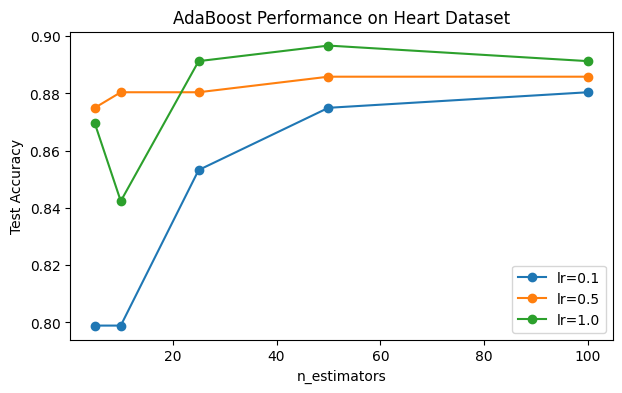


Best Configuration → lr=1.0, n=50, acc=0.8967


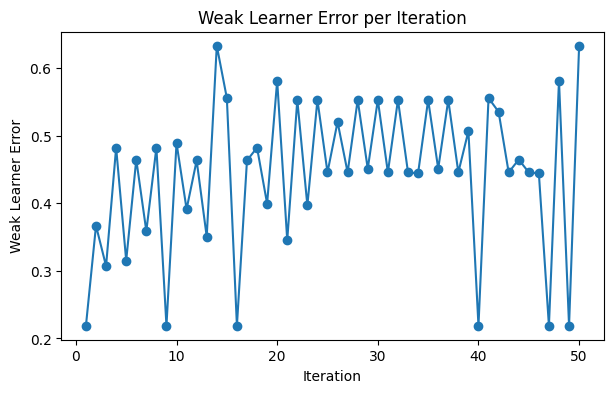


Top 5 Important Features:
id: 4.2199
slope_nan: 1.3165
trestbps: 1.0537
ca: 1.0077
oldpeak: 0.9059


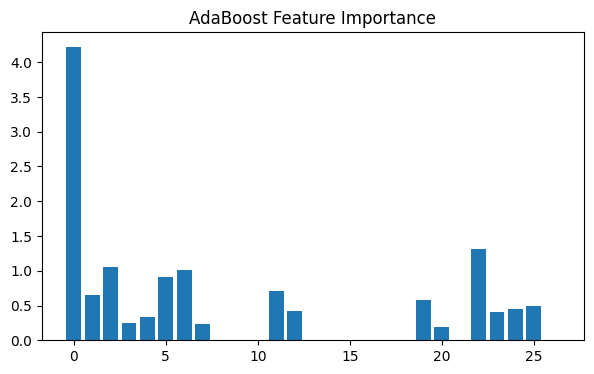

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

df = pd.read_csv("heart_disease_uci.csv")


df["target"] = df["num"].apply(lambda x: 0 if x == 0 else 1)

y = df["target"]
X = df.drop(columns=["target", "num"])


X2 = X.copy()


cat_cols = [c for c in X2.columns if X2[c].nunique() <= 6 and X2[c].dtype != float]
for c in cat_cols:
    X2[c] = X2[c].astype(str)

X2 = pd.get_dummies(X2, drop_first=True)

X2 = X2.fillna(X2.mean())


scaler = StandardScaler()
Xs = pd.DataFrame(scaler.fit_transform(X2), columns=X2.columns)


X_train, X_test, y_train, y_test = train_test_split(
    Xs.values, y.values, test_size=0.2, random_state=42, stratify=y
)


stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

print("\n--- Decision Stump Baseline ---")
print("Train acc:", accuracy_score(y_train, stump.predict(X_train)))
print("Test acc :", accuracy_score(y_test, stump.predict(X_test)))
print("Confusion:")
print(confusion_matrix(y_test, stump.predict(X_test)))
print("\nClassification Report:")
print(classification_report(y_test, stump.predict(X_test)))

# ===== ADABOOST GRID SEARCH =====
results = {}
learning_rates = [0.1, 0.5, 1.0]
n_estimators = [5, 10, 25, 50, 100]

print("\n--- AdaBoost Grid Search ---")
for lr in learning_rates:
    acc_list = []
    for n in n_estimators:
        clf = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n,
            learning_rate=lr
        )
        clf.fit(X_train, y_train)
        acc = accuracy_score(y_test, clf.predict(X_test))
        acc_list.append(acc)
        print(f"lr={lr}, n={n}, test_acc={acc:.4f}")
    results[lr] = acc_list


plt.figure()
for lr, accs in results.items():
    plt.plot(n_estimators, accs, marker="o", label=f"lr={lr}")
plt.xlabel("n_estimators")
plt.ylabel("Test Accuracy")
plt.title("AdaBoost Performance on Heart Dataset")
plt.legend()
plt.show()


best_acc = -1
for lr, accs in results.items():
    for n, acc in zip(n_estimators, accs):
        if acc > best_acc:
            best_acc = acc
            best_lr = lr
            best_n = n

print(f"\nBest Configuration → lr={best_lr}, n={best_n}, acc={best_acc:.4f}")


best_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=best_n,
    learning_rate=best_lr
)
best_clf.fit(X_train, y_train)

# Weak learner errors
errors = []
for est in best_clf.estimators_:
    pred = est.predict(X_train)
    errors.append(np.mean(pred != y_train))

plt.plot(range(1, len(errors)+1), errors, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Weak Learner Error")
plt.title("Weak Learner Error per Iteration")
plt.show()

# ===== FEATURE IMPORTANCE =====
importances = np.zeros(Xs.shape[1])
for est, wt in zip(best_clf.estimators_, best_clf.estimator_weights_):
    importances += wt * est.feature_importances_

idx = np.argsort(importances)[::-1][:5]

print("\nTop 5 Important Features:")
for i in idx:
    print(f"{Xs.columns[i]}: {importances[i]:.4f}")

plt.figure()
plt.bar(range(len(importances)), importances)
plt.title("AdaBoost Feature Importance")
plt.show()


Loaded rows: 154899
Train class counts: [57204 51225]
Test class counts: [24516 21954]

--- Decision Stump Baseline (WISDM) ---
Train acc: 0.66131754419943
Test acc : 0.6636970088228965
Confusion matrix:
[[23953   563]
 [15065  6889]]

Iteration 1
Misclassified indices: [2, 3, 11, 14, 19, 26, 30, 31, 32, 34] ...
Misclassified weights: [1.4e-05, 1.4e-05, 1.4e-05, 1.4e-05, 1.4e-05, 1.4e-05, 1.4e-05, 1.4e-05, 1.4e-05, 1.4e-05] ...
Alpha: 0.33458558217565704

Iteration 2
Misclassified indices: [0, 1, 2, 4, 5, 7, 8, 9, 10, 12] ...
Misclassified weights: [9e-06, 9e-06, 1.7e-05, 9e-06, 9e-06, 9e-06, 9e-06, 9e-06, 9e-06, 9e-06] ...
Alpha: 0.18635568230062885

Iteration 3
Misclassified indices: [3, 6, 11, 14, 15, 19, 20, 25, 26, 30] ...
Misclassified weights: [1.4e-05, 7e-06, 1.4e-05, 1.4e-05, 7e-06, 1.4e-05, 7e-06, 7e-06, 1.4e-05, 1.4e-05] ...
Alpha: 0.16344022029767502

Iteration 4
Misclassified indices: [0, 1, 2, 4, 5, 7, 8, 9, 10, 12] ...
Misclassified weights: [8e-06, 8e-06, 1.7e-05, 8e-06

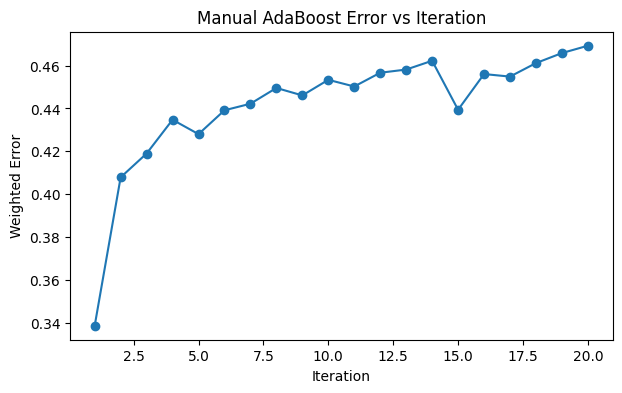

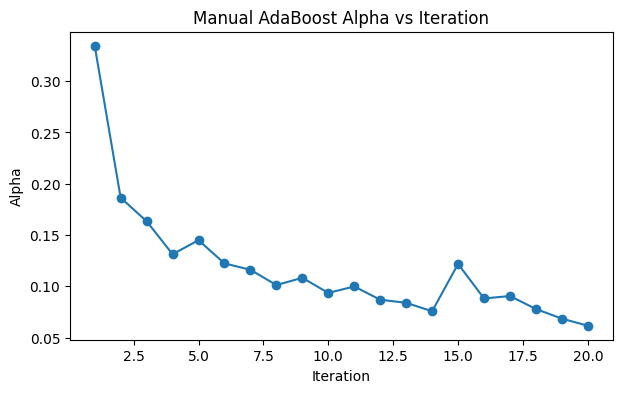


--- Manual AdaBoost Final Results (WISDM) ---
Train acc: 0.7385570281013382
Test acc : 0.7382182052937379
Confusion matrix:
[[22933  1583]
 [10582 11372]]

--- Sklearn AdaBoost (WISDM) ---
Train acc: 0.7512196921487794
Test acc : 0.7503550677856682
Confusion matrix:
[[22850  1666]
 [ 9935 12019]]


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


file = "WISDM_ar_v1.1_raw.txt"

rows = []
with open(file) as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        if line.endswith(";"):
            line = line[:-1]
        parts = line.split(",")
        if len(parts) < 6:
            continue

        user = parts[0]
        activity = parts[1]
        ts = parts[2]

        try:
            x = float(parts[3])
            y = float(parts[4])
            z = float(parts[5])
        except:
            continue

        rows.append((user, activity, int(ts), x, y, z))

df = pd.DataFrame(rows, columns=["user","activity","timestamp","x","y","z"])
print("Loaded rows:", len(df))



def map_act(a):
    a = a.lower()
    if "jog" in a or "up" in a:
        return 1   # vigorous
    return 0       # normal

df["label"] = df["activity"].apply(map_act)

X = df[["x","y","z"]].values
y = df["label"].values



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train class counts:", np.bincount(y_train))
print("Test class counts:", np.bincount(y_test))



stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

print("\n--- Decision Stump Baseline (WISDM) ---")
print("Train acc:", accuracy_score(y_train, stump.predict(X_train)))
print("Test acc :", accuracy_score(y_test, stump.predict(X_test)))
print("Confusion matrix:")
print(confusion_matrix(y_test, stump.predict(X_test)))



def manual_adaboost_numeric(X_train, y_train, X_test, y_test, T=20):
    n = X_train.shape[0]
    w = np.ones(n) / n
    y_signed = np.where(y_train == 1, 1, -1)

    models = []
    errors = []
    alphas = []

    for t in range(1, T + 1):
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X_train, y_train, sample_weight=w)

        pred = clf.predict(X_train)
        pred_signed = np.where(pred == 1, 1, -1)

        mis = (pred != y_train)
        err = np.sum(w[mis])
        err = max(min(err, 0.999999), 1e-12)

        alpha = 0.5 * np.log((1 - err) / err)

        w = w * np.exp(-alpha * y_signed * pred_signed)
        w = w / np.sum(w)

        mis_idx = np.where(mis)[0]

        print(f"\nIteration {t}")
        print("Misclassified indices:", mis_idx[:10].tolist(), "...")
        print("Misclassified weights:", w[mis_idx][:10].round(6).tolist(), "...")
        print("Alpha:", float(alpha))

        models.append((clf, alpha))
        errors.append(err)
        alphas.append(alpha)


    plt.plot(range(1, T+1), errors, marker="o")
    plt.xlabel("Iteration")
    plt.ylabel("Weighted Error")
    plt.title("Manual AdaBoost Error vs Iteration")
    plt.show()

    plt.plot(range(1, T+1), alphas, marker="o")
    plt.xlabel("Iteration")
    plt.ylabel("Alpha")
    plt.title("Manual AdaBoost Alpha vs Iteration")
    plt.show()


    def predict_boost(X):
        agg = np.zeros(X.shape[0])
        for m, a in models:
            p = m.predict(X)
            p_signed = np.where(p == 1, 1, -1)
            agg += a * p_signed
        return np.where(agg > 0, 1, 0)

    ytr_pred = predict_boost(X_train)
    yte_pred = predict_boost(X_test)

    print("\n--- Manual AdaBoost Final Results (WISDM) ---")
    print("Train acc:", accuracy_score(y_train, ytr_pred))
    print("Test acc :", accuracy_score(y_test, yte_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, yte_pred))

    return models, errors, alphas



models_w, errors_w, alphas_w = manual_adaboost_numeric(
    X_train, y_train, X_test, y_test, T=20
)



clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0
)
clf.fit(X_train, y_train)

print("\n--- Sklearn AdaBoost (WISDM) ---")
print("Train acc:", accuracy_score(y_train, clf.predict(X_train)))
print("Test acc :", accuracy_score(y_test, clf.predict(X_test)))
print("Confusion matrix:")
print(confusion_matrix(y_test, clf.predict(X_test)))


In [15]:
import pandas as pd

df = pd.read_csv("heart_disease_uci.csv")
df.head()
df.columns


Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')